In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.constants import c as clight
from astropy.constants import e as e_elec
from astropy.constants import h as hplanck
from astropy.cosmology import WMAP9 as cosmo

plt.rcParams["text.usetex"]=True
plt.rcParams["axes.labelsize"]=20
plt.rcParams["xtick.labelsize"]=20
plt.rcParams["ytick.labelsize"]=20
plt.rcParams["legend.fontsize"]=20

In [2]:
1./0.1287-1

6.770007770007769

In [3]:
zqso=6.38
Hz=cosmo.H(zqso).value
H0=cosmo.H(0).value

In [3]:
Req=18 #pMpc
xi=0.67
kapbg=10**(-24.5) #cm^-2 wrong, cm^-1

In [3]:
def kap(drArr,Req,xi,kapbg):
    """
    Calculate kappa profile given inputs.

    Parameters:
    - drArr: array of radial step sizes in pMpc
    - Req: characteristic scale in pMpc, where \Gamma_qso==\Gamma_bkg assuming pure geometric dillusion
    - xi: power-law index
    - kapbg: background opacity in 1/pMpc

    Returns:
    - kapr: array of kappa values at each radial step
    """
    rArr=np.cumsum(drArr)
    kapbg*=3.08e24 #convert to 1/pMpc
    Gq_o_Gbg=np.zeros_like(rArr)
    kapr=np.zeros_like(rArr)
    kapr[0]=0
    Gq_o_Gbg[0]=(rArr[0]/Req)**(-2) #Eq7
    for i in range(1,len(rArr)):
        kapr[i]=kapbg*(1+Gq_o_Gbg[i-1])**(-xi) #Eq4
        Gq_o_Gbg[i]=Gq_o_Gbg[i-1]*(rArr[i]/rArr[i-1])**(-2)*np.exp(-kapr[i-1]*drArr[i-1]) #Eq8
    return kapr#,Gq_o_Gbg

In [4]:
def tau_LyC(wv_rest,Req,xi,kapbg,debug=True):
    z912=wv_rest/911.76*(1+zqso)-1
#     print(z912)
    ngrid=10000
    dzpArr=np.ones(ngrid)*(zqso-z912)/ngrid
    zpArr=z912+(np.cumsum(dzpArr)-dzpArr[0]/2)
    drArr=dzpArr/Hz*clight.to("km/s").value/(1+zqso)
#     print(np.sum(drArr))
#     print((911.76-wv_rest)/911.76*clight.to("km/s").value/Hz)
    kap_zp=kap(drArr,Req,xi,kapbg)
    
    integ=(np.sum(kap_zp*(1+zpArr)**(-5.25)*dzpArr))
    tau_eff=clight.to("km/s").value/H0/cosmo.Om0**0.5*(1+z912)**2.75*integ
#     if debug==True:
#         return drArr,kap_zp,tau_eff
    return tau_eff

def convert_mfp_kapbg(wv_rest,kapbg):
    z912=wv_rest/911.76*(1+zqso)-1
    ngrid=10000
    dzpArr=np.ones(ngrid)*(zqso-z912)/ngrid
    zpArr=z912+(np.cumsum(dzpArr)-dzpArr[0]/2)
    drArr=dzpArr/Hz*clight.to("km/s").value/(1+zqso)
    kap_zp=np.ones_like(drArr)*kapbg*3.08e24
    integ=(np.sum(kap_zp*(1+zpArr)**(-5.25)*dzpArr))
    return clight.to("km/s").value/H0/cosmo.Om0**0.5*(1+z912)**2.75*integ

### load data (no qso)

In [20]:
wv_rest_arr=np.loadtxt("AAout.txt")
tau_profiles_noqso=np.loadtxt("tau_profiles_noq_z63.txt")

In [21]:
mean_p_noq=np.mean(np.exp(-tau_profiles_noqso),axis=0)
median_p_noq=np.median(np.exp(-tau_profiles_noqso),axis=0)

In [38]:
AAout=wv_rest_arr
clight_kmps=clight.to("km/s").value
mfp=clight_kmps*(911.6485294117647-AAout[np.argmin(np.abs(mean_p_noq-1/np.e))])/911.6485294117647/Hz
mfp

1.2809445366286039

In [10]:
plt.rcParams["text.usetex"]=True
plt.rcParams["axes.labelsize"]=20
plt.rcParams["xtick.labelsize"]=20
plt.rcParams["ytick.labelsize"]=20
plt.rcParams["legend.fontsize"]=14
plt.rcParams["legend.title_fontsize"]=14

/data/hqchen/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/data/hqchen/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/data/hqchen/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/data/hqchen/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


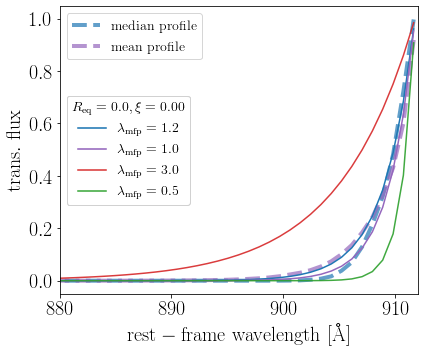

In [12]:
fig=plt.figure(figsize=(6,5)) 
axes = fig.subplots()

line1,=plt.plot(wv_rest_arr,median_p_noq,label=r"$\rm median \ profile$",lw=4,color="tab:blue",alpha=0.7,ls="--")

line2,=plt.plot(wv_rest_arr,mean_p_noq,label=r"$\rm mean \ profile$",lw=4,color="tab:purple",alpha=0.7,ls="--")
legend1 = plt.legend(handles=[line1, line2], loc='upper left')


Req=0 #pMpc
xi=0
mfp=1.2
kapbg=1./(mfp*3.08e24)

tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

line3,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp),color="tab:blue")

Req=0 #pMpc
xi=0
mfp=1
kapbg=1./(mfp*3.08e24)

tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

line4,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp),color="tab:purple")





mfp=3
kapbg=1./(mfp*3.08e24)
tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])
line5,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp),\
                color="tab:red",alpha=0.9)

mfp=0.5
kapbg=1./(mfp*3.08e24)
tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])
line6,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp),\
                color="tab:green",alpha=0.9)



legend2 = plt.legend(handles=[line3, line4, line5, line6], loc='center left')
legend2.set_title(r"$R_{{\rm eq}}={:3.1f},\xi={:4.2f}$".format(Req,xi))
axes.add_artist(legend1)
axes.add_artist(legend2)
plt.xlim(880,912)
plt.xlabel(r"$\rm rest-frame \  wavelength \ [\r{A}]$")
plt.ylabel(r"$\rm trans. \ flux$")
plt.tight_layout()

plt.savefig("sim_noq_beckermodel_z64.pdf")

In [32]:
1./(5*3.08e24)

6.493506493506493e-26

### load data (with qso)

### z=5.9

In [39]:
wv_rest_arr=np.loadtxt("AAout.txt")
qso_t1e7_tau_profiles=np.loadtxt("qso_t1e7_tau_profiles.txt")

In [40]:
mean_p=np.mean(np.exp(-qso_t1e7_tau_profiles),axis=0)
median_p=np.median(np.exp(-qso_t1e7_tau_profiles),axis=0)

In [41]:
plt.rcParams["text.usetex"]=True
plt.rcParams["axes.labelsize"]=20
plt.rcParams["xtick.labelsize"]=20
plt.rcParams["ytick.labelsize"]=20
plt.rcParams["legend.fontsize"]=14
plt.rcParams["legend.title_fontsize"]=14

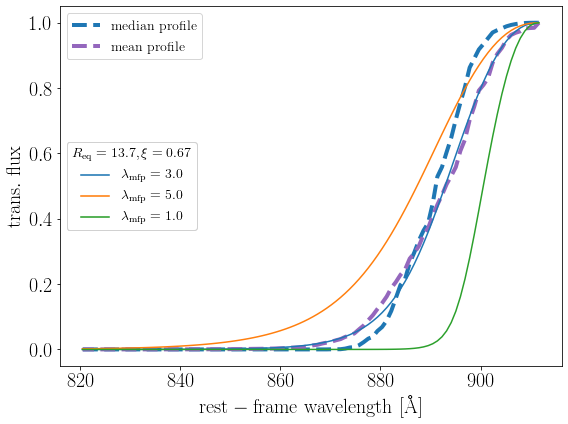

In [43]:
fig=plt.figure(figsize=(8,6)) 
axes = fig.subplots()

line1,=plt.plot(wv_rest_arr,median_p,label=r"$\rm median \ profile$",lw=4,color="tab:blue",ls="--")

line2,=plt.plot(wv_rest_arr,mean_p,label=r"$\rm mean \ profile$",lw=4,color="tab:purple",ls="--")
legend1 = plt.legend(handles=[line1, line2], loc='upper left')


Req=13.7 #pMpc
xi=0.67
mfp=3
kapbg=1./(mfp*3.08e24)
tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

line3,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp))



mfp=5
kapbg=1./(mfp*3.08e24)
tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

line4,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp))




mfp=1
kapbg=1./(mfp*3.08e24)

tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

line5,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp))
legend2 = plt.legend(handles=[line3, line4,line5], loc='center left')
legend2.set_title(r"$R_{{\rm eq}}={:3.1f},\xi={:4.2f}$".format(Req,xi))




axes.add_artist(legend1)
axes.add_artist(legend2)

plt.xlabel(r"$\rm rest-frame \  wavelength \ [\r{A}]$")
plt.ylabel(r"$\rm trans. \ flux$")
plt.tight_layout()

# plt.savefig("sim_beckermodel.pdf")

In [16]:
wv_rest_arr=np.loadtxt("AAout.txt")
qso_t1e7_tau_profiles=np.loadtxt("/data/hqchen/mfp_project/data/qso_t1e7_tau_profiles_z64.txt")
mean_p=np.mean(np.exp(-qso_t1e7_tau_profiles),axis=0)
median_p=np.median(np.exp(-qso_t1e7_tau_profiles),axis=0)

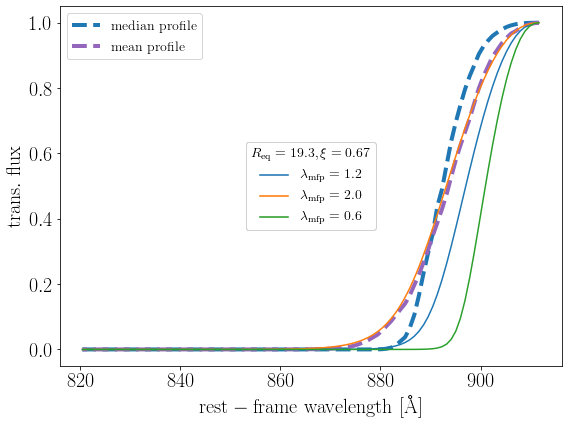

In [35]:
fig=plt.figure(figsize=(8,6)) 
axes = fig.subplots()

line1,=plt.plot(wv_rest_arr,median_p,label=r"$\rm median \ profile$",lw=4,color="tab:blue",ls="--")

line2,=plt.plot(wv_rest_arr,mean_p,label=r"$\rm mean \ profile$",lw=4,color="tab:purple",ls="--")
legend1 = plt.legend(handles=[line1, line2], loc='upper left')


# Req=13.5 #pMpc
# xi=0.67
# mfp=2.5
# kapbg=1./(mfp*3.08e24)
# tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

# line3,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp))


# mfp=5
# kapbg=1./(mfp*3.08e24)
# tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

# line4,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp))

# mfp=1
# kapbg=1./(mfp*3.08e24)

# tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

# line5,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp))
# legend2 = plt.legend(handles=[line3, line4,line5], loc='center left')
# legend2.set_title(r"$R_{{\rm eq}}={:3.1f},\xi={:4.2f}$".format(Req,xi))


Req=19.3 #pMpc
xi=0.67
mfp=1.2
kapbg=1./(mfp*3.08e24)
tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

line6,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp))


mfp=2
kapbg=1./(mfp*3.08e24)
tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

line7,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp))

mfp=0.6
kapbg=1./(mfp*3.08e24)

tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

line8,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp))
legend3 = plt.legend(handles=[line6, line7,line8], loc='center')
legend3.set_title(r"$R_{{\rm eq}}={:3.1f},\xi={:4.2f}$".format(Req,xi))


axes.add_artist(legend1)
# axes.add_artist(legend2)
axes.add_artist(legend3)

plt.xlabel(r"$\rm rest-frame \  wavelength \ [\r{A}]$")
plt.ylabel(r"$\rm trans. \ flux$")
plt.tight_layout()

# plt.savefig("sim_beckermodel.pdf")

### z=6.1

In [6]:
auni=0.1401
zqso=1/auni-1
print(zqso)
Hz=cosmo.H(zqso).value
H0=cosmo.H(0).value

6.137758743754461


In [7]:
wv_rest_arr=np.loadtxt("/data/hqchen/mfp_project/data/AAout.txt")
qso_t1e7_tau_profiles=np.load("/data/hqchen/mfp_project/data/qso_t1e7_tau_profiles_z61.npy")

mean_p=np.mean(np.exp(-qso_t1e7_tau_profiles),axis=0)
median_p=np.median(np.exp(-qso_t1e7_tau_profiles),axis=0)

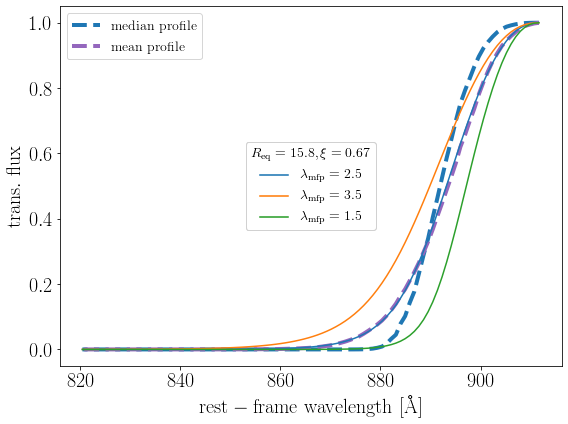

In [15]:
fig=plt.figure(figsize=(8,6)) 
axes = fig.subplots()

line1,=plt.plot(wv_rest_arr,median_p,label=r"$\rm median \ profile$",lw=4,color="tab:blue",ls="--")

line2,=plt.plot(wv_rest_arr,mean_p,label=r"$\rm mean \ profile$",lw=4,color="tab:purple",ls="--")
legend1 = plt.legend(handles=[line1, line2], loc='upper left')


# Req=13.5 #pMpc
# xi=0.67
# mfp=2.5
# kapbg=1./(mfp*3.08e24)
# tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

# line3,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp))


# mfp=5
# kapbg=1./(mfp*3.08e24)
# tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

# line4,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp))

# mfp=1
# kapbg=1./(mfp*3.08e24)

# tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

# line5,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp))
# legend2 = plt.legend(handles=[line3, line4,line5], loc='center left')
# legend2.set_title(r"$R_{{\rm eq}}={:3.1f},\xi={:4.2f}$".format(Req,xi))


Req=15.8 #pMpc
xi=0.67
mfp=2.5
kapbg=1./(mfp*3.08e24)
tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

line6,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp))


mfp=3.5
kapbg=1./(mfp*3.08e24)
tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

line7,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp))

mfp=1.5
kapbg=1./(mfp*3.08e24)

tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

line8,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp))
legend3 = plt.legend(handles=[line6, line7,line8], loc='center')
legend3.set_title(r"$R_{{\rm eq}}={:3.1f},\xi={:4.2f}$".format(Req,xi))


axes.add_artist(legend1)
# axes.add_artist(legend2)
axes.add_artist(legend3)

plt.xlabel(r"$\rm rest-frame \  wavelength \ [\r{A}]$")
plt.ylabel(r"$\rm trans. \ flux$")
plt.tight_layout()

# plt.savefig("sim_beckermodel.pdf")

In [5]:
auni=0.1287
zqso=1/auni-1
print(zqso)
Hz=cosmo.H(zqso).value
H0=cosmo.H(0).value

wv_rest_arr=np.loadtxt("/data/hqchen/mfp_project/data/AAout.txt")
qso_t1e7_tau_profiles=np.load("/data/hqchen/mfp_project/data/qso_t1e7_tau_profiles_z61.npy")

mean_p=np.mean(np.exp(-qso_t1e7_tau_profiles),axis=0)
median_p=np.median(np.exp(-qso_t1e7_tau_profiles),axis=0)

6.770007770007769


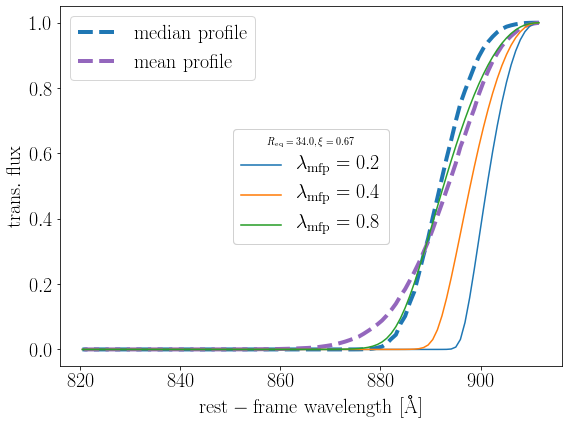

In [14]:
fig=plt.figure(figsize=(8,6)) 
axes = fig.subplots()

line1,=plt.plot(wv_rest_arr,median_p,label=r"$\rm median \ profile$",lw=4,color="tab:blue",ls="--")

line2,=plt.plot(wv_rest_arr,mean_p,label=r"$\rm mean \ profile$",lw=4,color="tab:purple",ls="--")
legend1 = plt.legend(handles=[line1, line2], loc='upper left')


# Req=15 #pMpc
# xi=0.67
# mfp=0.1
# kapbg=1./(mfp*3.08e24)
# tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

# line3,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp))

# mfp=0.4
# kapbg=1./(mfp*3.08e24)
# tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

# line4,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp))

# mfp=1
# kapbg=1./(mfp*3.08e24)

# tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

# line5,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp))
# legend2 = plt.legend(handles=[line3, line4,line5], loc='center left')
# legend2.set_title(r"$R_{{\rm eq}}={:3.1f},\xi={:4.2f}$".format(Req,xi))


Req=34 #pMpc
xi=0.67
mfp=0.2
kapbg=1./(mfp*3.08e24)
tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

line6,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp))


mfp=0.38
kapbg=1./(mfp*3.08e24)
tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

line7,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp))

mfp=0.8
kapbg=1./(mfp*3.08e24)

tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

line8,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp))
legend3 = plt.legend(handles=[line6, line7,line8], loc='center')
legend3.set_title(r"$R_{{\rm eq}}={:3.1f},\xi={:4.2f}$".format(Req,xi))


axes.add_artist(legend1)
# axes.add_artist(legend2)
axes.add_artist(legend3)

plt.xlabel(r"$\rm rest-frame \  wavelength \ [\r{A}]$")
plt.ylabel(r"$\rm trans. \ flux$")
plt.tight_layout()

# plt.savefig("sim_beckermodel.pdf")